In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
import tensorflow as tf
import random


seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
dde.config.set_random_seed(0)

print(tf.__version__)

def pde(x, y):
    dde.config.set_random_seed(0)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0) # derivando a primeira variavel dependente com a relacao a primeira variavel indepedente
    dy_t = dde.grad.jacobian(y, x, i=0, j=1) # derivando a primeira variavel dependente com a relacao a segunda variavel indepedente
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0) #cálculo da 3a derivada!
    return dy_t - (3/2) * y * dy_x - (1/6)* dy_xxx

dde.config.set_random_seed(0)
xmin = -50
xmax = 50
tmin = 0
tmax = 30  # mudar para 60

geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(tmin, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], xmin)
def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], xmax)

bc1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left) # Condicao de fronteira a esquerda
bc2 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)

A = 1
k = np.sqrt(3*A/4)
ic = dde.icbc.IC(geomtime, lambda x: A*(1/np.cosh(k*(x[:, 0:1]))**2), lambda _, on_initial: on_initial)

def analytical_solution(x, t):
    dde.config.set_random_seed(0)
    A = 1
    k = np.sqrt(3 * A / 4)
    c = -A / 2
    return A / np.cosh(k * (x - c * t)) ** 2

2.17.1


7 6
Compiling model...
'compile' took 0.000694 s

Training model...



Step      Train loss                                  Test loss                                   Test metric
0         [5.20e-04, 6.75e-02, 7.58e-02, 1.05e-01]    [5.20e-04, 6.75e-02, 7.58e-02, 1.05e-01]    []  
709       [1.26e-07, 6.96e-11, 6.52e-11, 2.42e-08]    [1.26e-07, 6.96e-11, 6.52e-11, 2.42e-08]    []  

Best model at step 709:
  train loss: 1.50e-07
  test loss: 1.50e-07
  test metric: []

'train' took 239.702269 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/while_loop.py", line 487, in while_loop
    while cond(*loop_vars):  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/functional_ops.py", line 653, in compute
    return (next_i, flat_a_out, tas)  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/functional_ops.py", line 648, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_a_out)]  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_w

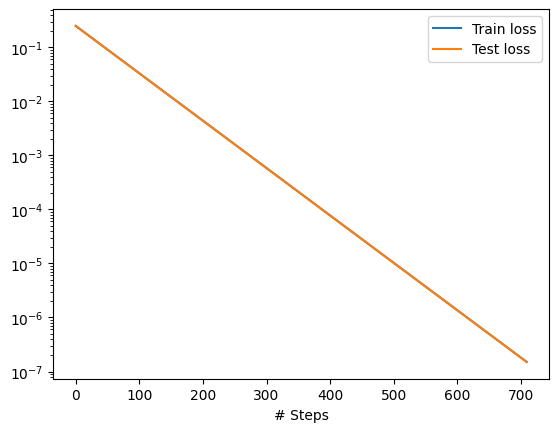

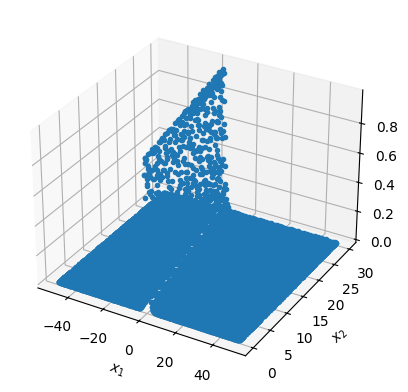

5.19687374e-03


In [ ]:
from time import time
from numpy import linalg as LA
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
dde.config.set_random_seed(0)

dados = []

erros = []
camada = 7
neuronio = 6
# while camada <= 10:
# lista = []
print(camada, neuronio)
data = dde.data.TimePDE(geomtime, pde, [bc1, bc2, ic], num_domain=15000, num_boundary=300, num_initial=300)
# data = dde.data.TimePDE(geomtime, pde, ic, num_domain=30000, num_boundary=500, num_initial=500)  # Aqui roda sem a fronteira
net = dde.nn.FNN([2] + [neuronio] * camada + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)


t0 = time()
model.compile("adam", lr=1e-3)  # mexer no lr pode ser uma ideia??
model.train(iterations=30000)
resampler = dde.callbacks.PDEPointResampler(period=10)
losshistory, train_state = model.train(display_every = 1, callbacks = [resampler])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
t1 = time()
tempo = t1-t0
x = np.linspace(-50, 50, 1000)
t = np.linspace(0, 30, 1000)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

# Calcular a solução analítica na mesma grade que a previsão da rede neural
analytical_prediction = analytical_solution(X, T)

y_pred = prediction.reshape(1000,1000)
erro = LA.norm(y_pred-analytical_prediction, 'fro') / LA.norm(analytical_prediction, 'fro')
# Use a notação exponencial para imprimir o valor
print("{:.8e}".format(erro))
# lista.append(neuronio)
# lista.append(camada)
# lista.append(erro)
# dados.append(lista)
# neuronio += 1
# camada += 1
# print(dados)

In [ ]:
import scipy.io as sio
sio.savemat('KdV_teste_lbfgs.mat', {'y_pred':y_pred})